In [1]:
import pandas as pd
import numpy as np
import datetime
import statsmodels as sm
import matplotlib.pyplot as plt
import seaborn as sns 
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller, acf, pacf
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.seasonal import seasonal_decompose
from matplotlib.pylab import rcParams
import matplotlib
import folium
import warnings
import matplotlib.ticker as ticker
from sklearn.model_selection import TimeSeriesSplit
import pmdarima as pm
%matplotlib inline

In [2]:
df_raw = pd.read_csv('data/or_ev_registrations_public.csv')

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3145: DtypeWarning: Columns (2) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [3]:
years = pd.DataFrame(df_raw['Registration Valid Date'].value_counts().reset_index().values, columns=["Year", "Registered Vehicles"])

,Registered Vehicles
Year,
2019-01-19,3.0
2019-01-21,17.0
2019-01-22,39.0
2019-01-23,30.0
2019-01-24,42.0
...,...
2020-12-27,11.0
2020-12-28,59.0
2020-12-29,47.0


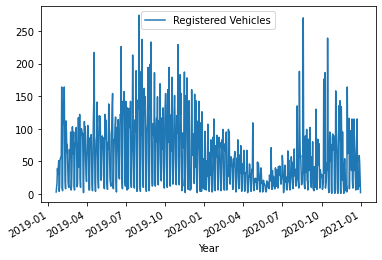

In [4]:
df = pd.DataFrame(years['Registered Vehicles'])
df = df.set_axis(pd.to_datetime(years['Year']))
df.plot()
df = df.sort_values(by=['Year'], ascending = True)
df = df.astype(float)
df

## **RESAMPLING

In [5]:
# # Interpolate - Backfill 
# df = df.resample('W').interpolate(method = 'linear')
# df = df.bfill()
# print(df.head())
# df.plot()

In [6]:
# # Backfill 
# df = df.resample('W').bfill()
# df.plot()

<AxesSubplot:xlabel='Year'>

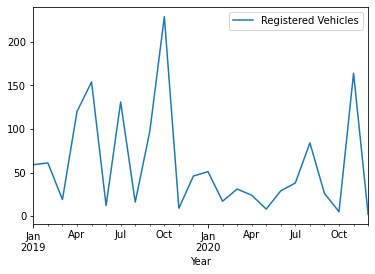

In [7]:
# #Frontfill 
df = df.resample('M').ffill()
df.plot()

## Testing 

In [8]:
adtest = adfuller(df)
display(adtest)

(-5.451761627304268,
 2.6347869354193045e-06,
 0,
 23,
 {'1%': -3.7529275211638033,
  '5%': -2.998499866852963,
  '10%': -2.6389669754253307},
 145.24617095753467)

## Modeling

In [19]:
# Splitting Training and Testing data; using after 2019 as test

train = df[:'2020-05']
test = df['2020-06':]
combined = df

test

,Registered Vehicles
Year,
2020-06-30,29.0
2020-07-31,38.0
2020-08-31,84.0
2020-09-30,26.0
2020-10-31,5.0
2020-11-30,164.0
2020-12-31,2.0


In [20]:
auto_model = pm.auto_arima(train, start_p=0, start_q=0,
                     test='adf',
                     max_p=6, max_q=6,
                     m=1,
                     d=0,
                     seasonal = True,
                     start_P=0,start_Q=0,
                     D=0,
                     trace=True,
                     error_action= 'ignore',
                     suppress_warnings=True,
                     stepwise=True,with_intercept=False)
print(auto_model.summary())



Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=202.490, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=200.359, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=201.691, Time=0.03 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=200.203, Time=0.03 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=197.723, Time=0.04 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=199.595, Time=0.05 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=inf, Time=0.09 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=199.018, Time=0.06 sec
 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=0.10 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=196.456, Time=0.08 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=195.566, Time=0.04 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=193.641, Time=0.04 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=191.852, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=193.625, Time=0.04 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=195.625, Time

### The best model is :  ARIMA (0, 0, 0) (0,0,0) [0]

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      8014.8408   2385.401      3.360      0.001    3339.541    1.27e+04


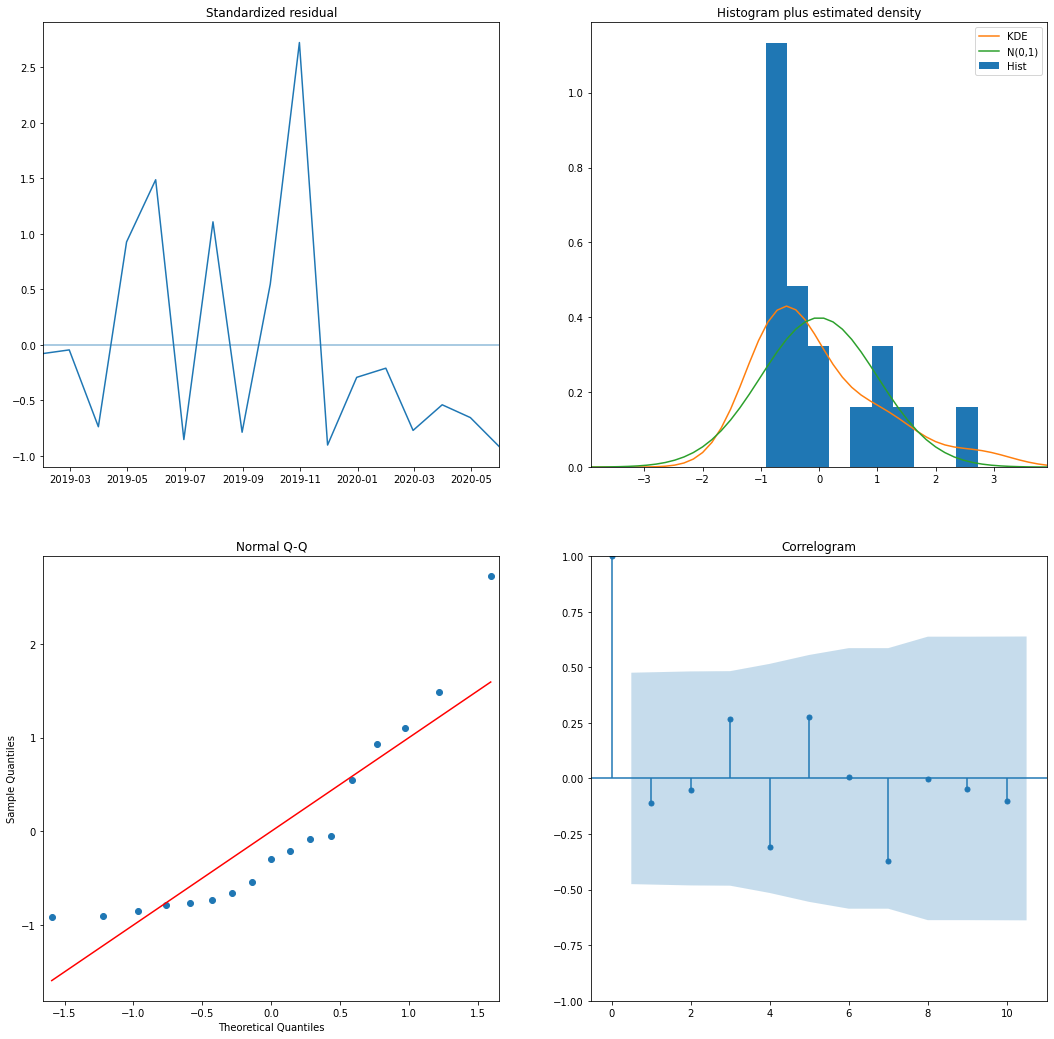

In [21]:
ARIMA_MODEL = sm.tsa.statespace.sarimax.SARIMAX(train, 
                                        order=(0,0,0), 
                                        seasonal_order=(0, 0, 0, 0), 
                                        enforce_stationarity=False, 
                                        enforce_invertibility=False)


output = ARIMA_MODEL.fit()

print(output.summary().tables[1])
auto_model.plot_diagnostics(figsize=(18,18))
plt.show()

In [23]:
pred = output.get_prediction(start=pd.to_datetime('2020-06-30'), end=pd.to_datetime('2020-12-31'), dynamic=False)
pred_conf = pred.conf_int()
pred_conf

,lower Registered Vehicles,upper Registered Vehicles
2020-06-30,-175.467036,175.467036
2020-07-31,-175.467036,175.467036
2020-08-31,-175.467036,175.467036
2020-09-30,-175.467036,175.467036
2020-10-31,-175.467036,175.467036
2020-11-30,-175.467036,175.467036
2020-12-31,-175.467036,175.467036


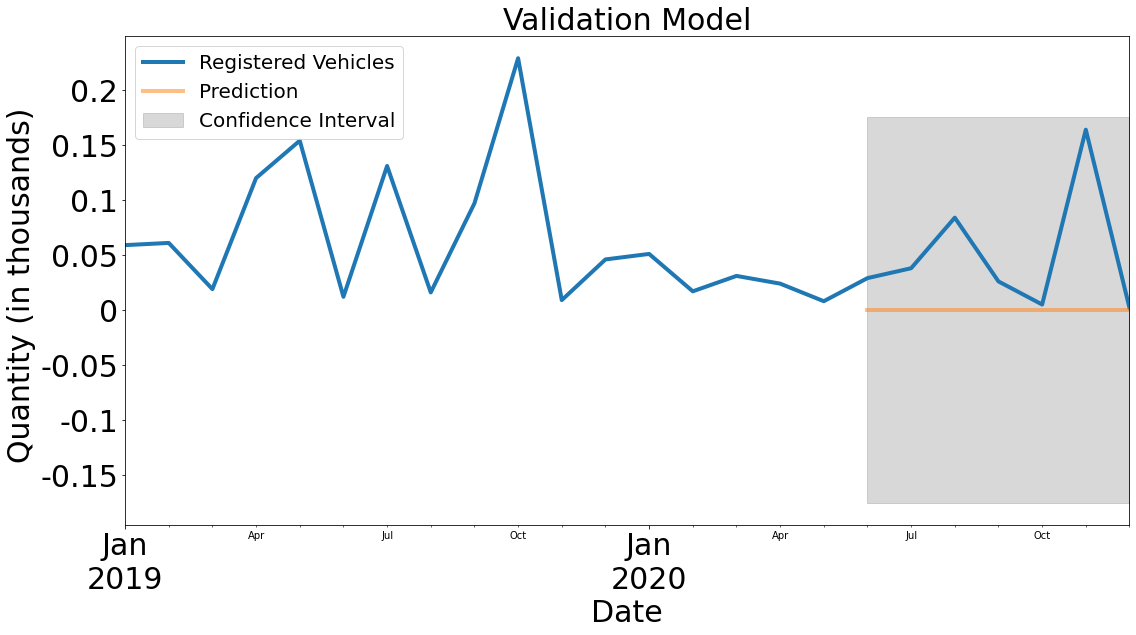

In [24]:


rcParams['figure.figsize'] = 18, 9
ax = df.plot(label='observed', linewidth = 4)

pred.predicted_mean.plot(ax=ax, label='Prediction', alpha=0.5, linewidth = 4)


ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='grey', alpha=0.3,label = 'Confidence Interval')


ax.set_xlabel('Date',fontsize=30)
plt.xticks(fontsize=30)
ax.set_ylabel('Quantity (in thousands) ',fontsize=30)
plt.yticks(fontsize=30)
scale_y = 1e3
ticks_y = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_y))
ax.yaxis.set_major_formatter(ticks_y)
ax.set_title('Validation Model',fontsize=30)
plt.legend(fontsize = 20)

plt.show()

In [25]:
# Beginning our forecasting for next 3 years (36 months)
ARIMA_MODEL = sm.tsa.statespace.sarimax.SARIMAX(combined, 
                                        order=(3,0,0), 
                                        seasonal_order=(0, 0, 0, 0), 
                                        enforce_stationarity=False, 
                                        enforce_invertibility=False)


full_output = ARIMA_MODEL.fit()

print(output.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      8014.8408   2385.401      3.360      0.001    3339.541    1.27e+04


In [26]:
forecast = full_output.get_forecast(36)
future_prediction = forecast.conf_int(alpha=.3)
future_prediction['value'] = forecast.predicted_mean
future_prediction.columns = ['lower','upper','prediction'] 
future_prediction

,lower,upper,prediction
2021-01-31,-28.422846,100.995717,36.286435
2021-02-28,35.784865,165.349734,100.567299
2021-03-31,-52.794642,79.449372,13.327365
2021-04-30,-34.560946,120.094130,42.766592
2021-05-31,-12.500619,142.688910,65.094145
2021-06-30,-59.551829,99.052927,19.750549
2021-07-31,-43.718546,123.283768,39.782611
2021-08-31,-38.964100,128.884738,44.960319
2021-09-30,-63.302349,107.391090,22.044370
2021-10-31,-53.226110,121.278089,34.025990


In [27]:
future_prediction['prediction'].sum()

809.4853894820545

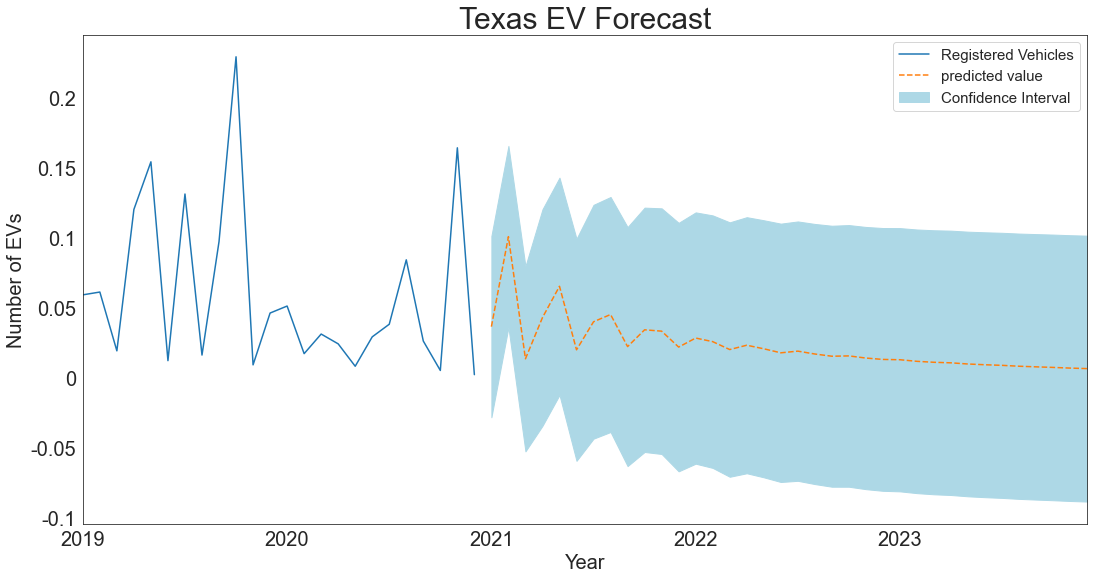

In [28]:
sns.set_style(style='white')
fig, ax = plt.subplots()
combined.plot(ax=ax,label='Actual')


future_prediction['prediction'].plot(ax=ax,label='predicted value',ls='--')

ax.fill_between(x= future_prediction.index, y1= future_prediction['lower'], 
                y2= future_prediction['upper'], color = 'lightblue',
                label='Confidence Interval')


ax.set_xlabel('Year',fontsize=20)
plt.xticks(fontsize=20)
ax.set_ylabel('Number of EVs',fontsize=20)
plt.yticks(fontsize=20)

# scale_y = 1e5
ticks_y = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_y))
ax.yaxis.set_major_formatter(ticks_y)
ax.set_title('Texas EV Forecast',fontsize=30)
plt.legend(fontsize = 15)
plt.show()